# I. Le Feature Engineering #

Dans ce cours, vous découvrirez l'une des étapes les plus importantes de la création d'un bon modèle d'apprentissage automatique : *le feature engineering (l'ingénierie des features ou caractéristiques ou fonctionnalités)*. Vous apprendrez à :
- déterminer quelles features sont les plus importantes avec *l'information mutuelle*
- inventer de nouvelles features dans plusieurs domaines de problèmes du monde réel (dans un autre notebook)
- encoder les catégories à haute cardinalité avec un *codage de cible* (dans un autre notebook)
- décomposer la variation d'un jeu de données en features avec *l'analyse en composantes principales (dans un autre notebook)*

Are you ready? Let's go!

### L'objectif du Feature Engineering #

L'objectif du feature engineering est simplement de rendre vos données mieux adaptées au problème posé.

Considérez les mesures de la « température apparente » comme l'indice de chaleur et le refroidissement éolien. Ces quantités tentent de mesurer la température *perçue* par les humains en fonction de la température de l'air, de l'humidité et de la vitesse du vent, des choses que nous pouvons mesurer directement. Vous pourriez penser à une température apparente comme le résultat d'une sorte de feature engineering, une tentative de rendre les données observées plus pertinentes par rapport à ce qui nous intéresse réellement : ce que l'on ressent réellement à l'extérieur !

Vous pouvez effectuer une ingénierie de features pour :
- améliorer les performances prédictives d'un modèle
- réduire les besoins de calcul ou de données
- améliorer l'interprétabilité des résultats

### Exemple - Formulations de béton #

Pour illustrer ces idées, nous verrons comment l'ajout de quelques caractéristiques synthétiques à un jeu de données peut améliorer les performances prédictives d'un modèle de forêt aléatoire (random forest).

Le dataset *Concrete* contient une variété de formulations de béton et la *résistance à la compression* du produit résultant, qui est une mesure de la charge que ce type de béton peut supporter. La tâche sur cet ensemble de données est de prédire la résistance à la compression d'un béton compte tenu de sa formulation.

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

df = pd.read_csv("../Data/data2/FE-Course-Data/concrete.csv")
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Vous pouvez voir ici les différents ingrédients entrant dans chaque variété de béton. Nous verrons dans un instant comment l'ajout de features synthétiques supplémentaires dérivées de celles-ci peut aider un modèle à apprendre des relations importantes entre elles.

Nous allons d'abord établir une base de référence en entraînant le modèle sur l'ensemble de données non augmenté. Cela nous aidera à déterminer si nos nouvelles features sont réellement utiles.

L'établissement de baselines comme celle-ci est une bonne pratique au début du processus de feature engineering. Un score de référence peut vous aider à décider si vos nouvelles features valent la peine d'être conservées ou si vous devez les supprimer et éventuellement essayer autre chose.

In [3]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(criterion="mae", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.232


Si vous cuisinez un jour à la maison, vous savez peut-être que le *rapport* d'ingrédients dans une recette est généralement un meilleur indicateur du résultat de la recette que leurs quantités absolues. Nous pourrions alors penser que les ratios des features ci-dessus seraient un bon prédicteur de la CompressiveStrength (Résistance à la compression).

La cellule ci-dessous ajoute trois nouvelles features de ratio au jeu de données.

In [4]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="mae", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.948


Et bien sûr, les performances se sont améliorées ! C'est la preuve que ces nouvelles features de ratio ont exposé au modèle des informations importantes qu'il ne détectait pas auparavant.

# II. Information Mutuelle

### Introduction #

La première rencontre avec un nouvel ensemble de données peut parfois sembler accablante. Des centaines ou des milliers de features peuvent vous être présentées sans même une description. Par où commencer ?

Une première étape importante consiste à construire un classement avec une **mesure d'utilité des features**, une fonction mesurant les associations entre une features et la cible (appelée aussi classe ou label). Ensuite, vous pouvez choisir un ensemble plus petit des features les plus utiles à développer initialement et avoir plus de confiance que votre temps sera bien dépensé.

La métrique que nous utiliserons s'appelle "l'informations mutuelle". L'information mutuelle ressemble beaucoup à la corrélation en ce sens qu'elle mesure une relation entre deux quantités. L'avantage de l'information mutuelle est qu'elle peut détecter *tout* type de relation, tandis que la corrélation ne détecte que les relations *linéaires*.

L'information mutuelle est une excellente mesure à usage général et particulièrement utile au début du développement de features lorsque vous ne savez peut-être pas encore quel modèle vous souhaitez utiliser. Elle est:
- facile à utiliser et à interpréter,
- efficace du point de vue informatique,
- théoriquement bien fondée,
- résistante au surapprentissage, et,
- capable de détecter tout type de relation

### L'information mutuelle et ce qu'elle mesure #

L'information mutuelle décrit les relations en termes d'*incertitude*. L'**information mutuelle** (IM) entre deux quantités est une mesure de l'étendue dans laquelle la connaissance d'une quantité réduit l'incertitude sur l'autre. Si vous connaissiez la valeur d'une feature, à quel point auriez-vous plus confiance en la cible ?

(Technical note: What we're calling uncertainty is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the cible.)

### Interpréter les scores d'information mutuelle #

La plus petite valeur d'information mutuelle possible entre les quantités est de 0,0. Quand IM est nulle, les quantités sont indépendantes: aucune autre ne peut vous dire quoi que ce soit sur l'autre. Inversement, en théorie, il n'y a pas de limité supérieure à ce que IM peut être. En pratique, les valeurs supérieures à 2,0 sont rares. (L'information mutuelle est une quantité logarithmique, elle augmente donc très lentement.)

Voici quelques points à retenir lors de l'application de l'information mutuelle:
- IM peut vous aider à comprendre le *potentiel relatif* d'une feature comme prédicteur de la cible, considérée en soi.
- Il est possible que la feature soit très informative en interagissant avec d'autres features, mais pas si informative toute seule. IM *ne peut pas détecter les interactions* entre les features. C'est une **métrique univariée**.
- L'utilité *réelle* d'une feature *dépend du modèle que vous l'utilisez avec*. Une feature ayant un score IM élevé ne signifie pas que votre modèle sera en mesure de faire quoi que ce soit avec ces informations. Vous devrez peut-être transformer la fonctionnalité d'abord pour exposer l'association.

### Example - 1985 Automobiles #

Le dataset [*Automobile*](https://www.kaggle.com/toramky/automobile-dataset) se compose de 193 voitures de l'année modèle 1985. L'objectif de cet ensemble de données est de prédire le "prix" d'une voiture à partir de 23 caractéristiques de la voiture, telles que `make`, `body_style` et `horsepower`. Dans cet exemple, nous allons classer les fonctionnalités avec des informations mutuelles et étudier les résultats par visualisation des données.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")

df = pd.read_csv("../Data/data2/FE-Course-Data/autos.csv")
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


L'algorithme scikit-learn pour l'IM traite les features discrètes différemment des features continues. Par conséquent, vous devez lui dire lesquels sont lesquels. En règle générale, tout ce qui *doit* avoir un type `float` n'est *pas* discret. Les features (type `object` ou `categorial`) peuvent être traités comme discrets en leur donnant un codage d'étiquette.

In [5]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

Scikit-learn a deux métriques d'informations mutuelles dans son module `feature_selection` : une pour les cibles à valeur réelle (`mutual_info_regression`) et une pour les cibles catégorielles (`mutual_info_classif`). Notre objectif, le « prix », est une valeur réelle. La cellule suivante calcule les scores IM pour nos features et les enveloppe dans une belle trame de données.

In [6]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

engine_size          0.918597
horsepower           0.893792
length               0.599828
fuel_system          0.467317
drive_wheels         0.332922
symboling            0.235823
compression_ratio    0.111795
fuel_type            0.048139
Name: MI Scores, dtype: float64

Et maintenant un graphique à barres pour faciliter les comparaisons :

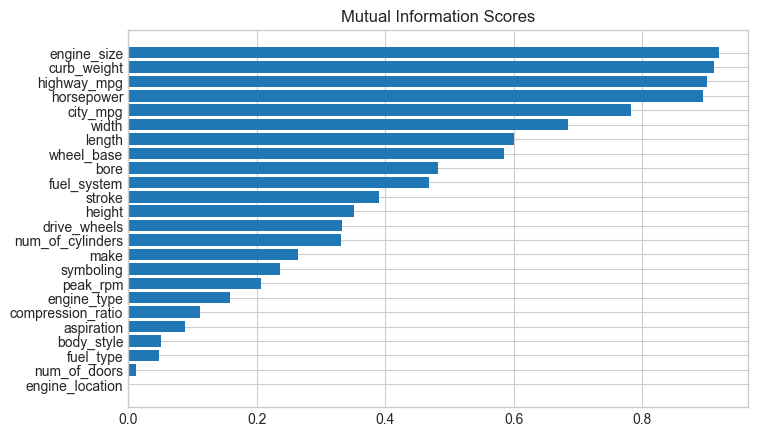

In [7]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Comme on pouvait s'y attendre, la fonction `curb_weight` à score élevé présente une forte relation avec `price`, la cible.

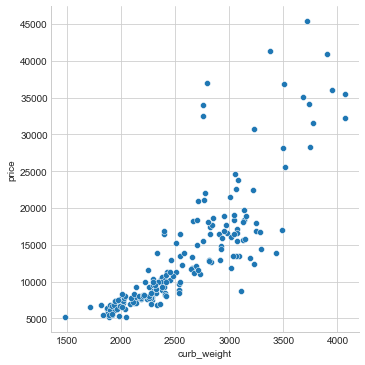

In [8]:
sns.relplot(x="curb_weight", y="price", data=df);

La feature `fuel_type` a un score d'IM assez faible, mais comme nous pouvons le voir sur la figure, elle sépare clairement deux populations `price` avec des tendances différentes au sein de la feature `horsepower`. Cela indique que `fuel_type` contribue à un effet d'interaction et n'est peut-être pas sans importance après tout. Avant de décider qu'une feature n'est pas importante à partir de son score IM, il est bon d'étudier tous les effets d'interaction possibles - la connaissance du domaine peut offrir de nombreux conseils ici.

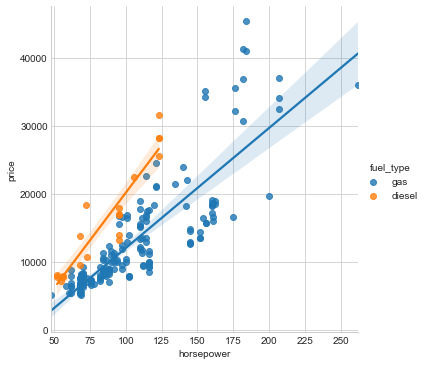

In [9]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

## 2.1 Exercice

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

In [6]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [7]:
# Load data
df = pd.read_csv("../Data/data2/FE-Course-Data/ames.csv")

In [8]:
# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [9]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

-------------------------------------------------------------------------------
Pour commencer, passons en revue la signification de l'information mutuelle en examinant quelques features du dataset *Ames*.

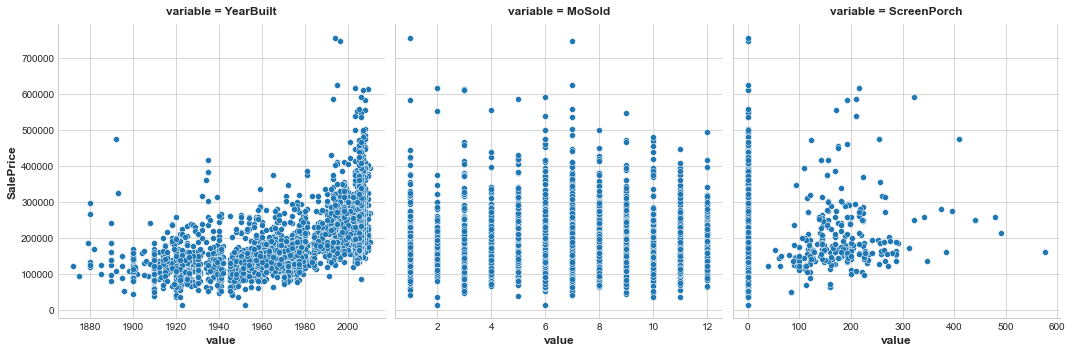

In [11]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

### 1) Comprendre l'Information Mutuelle

Sur la base des plots, quelle features pensez-vous aurait l'information mutuelle la plus élevée avec `SalePrice` ?

In [ ]:
# TODO:

-------------------------------------------------------------------------------
Le dataset *Ames* a soixante-dix-huit features - beaucoup ! Heureusement, vous pouvez identifier les fonctionnalités avec le plus de potentiel.

Utilisez la fonction `make_mi_scores` (présentée dans le tutoriel) pour calculer les scores d'informations mutuelles pour les fonctionnalités *Ames* :

In [12]:
X = df.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)

Examinez maintenant les scores à l'aide des fonctions de cette cellule. Regardez surtout les rangs supérieurs et inférieurs.

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64


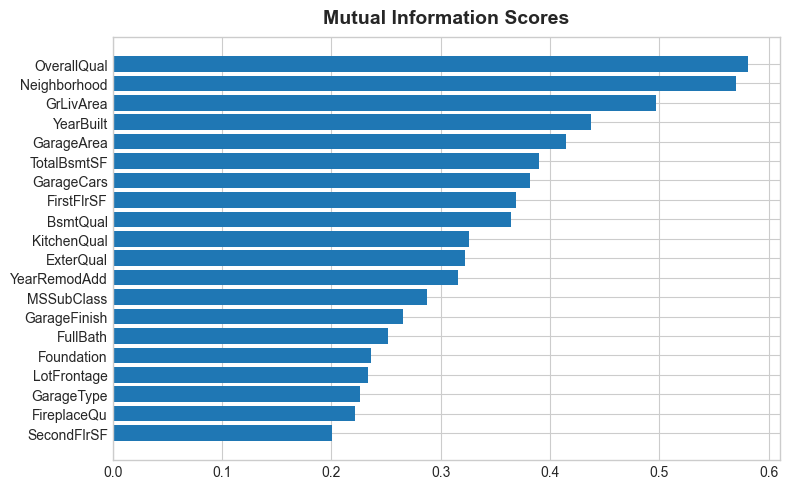

In [13]:
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

### 2) Examiner les scores IM

Les scores vous semblent-ils raisonnables ? Les features de score élevé représentent-elles des choses que vous pensez que la plupart des gens apprécieraient dans une maison ? Remarquez-vous des thèmes dans ce qu'ils décrivent ?

-------------------------------------------------------------------------------

Dans cette étape, vous étudierez les effets d'interaction possibles pour la feature « BldgType ». Cette feature décrit la structure générale du logement en cinq catégories :
> Bldg Type (Nominal): Type of dwelling
>		
>       1Fam	Single-family Detached	
>       2FmCon	Two-family Conversion; originally built as one-family dwelling
>       Duplx	Duplex
>       TwnhsE	Townhouse End Unit
>       TwnhsI	Townhouse Inside Unit

La feature `BldgType` n'a pas obtenu un score IM très élevé. Un graphique confirme que les catégories dans `BldgType` ne font pas un bon travail de distinction des valeurs dans `SalePrice` (les distributions semblent assez similaires, en d'autres termes) :

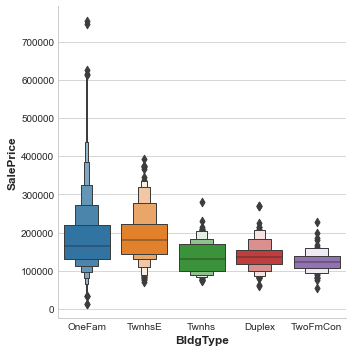

In [14]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");

Pourtant, le type de logement semble être une information importante. Vérifiez si `BldgType` produit une interaction significative avec l'un des éléments suivants :

```
GrLivArea  # Above ground living area
MoSold     # Month sold
```

Exécutez la cellule suivante deux fois : la première fois avec `feature = "GrLivArea"` et la prochaine fois avec `feature="MoSold"` :

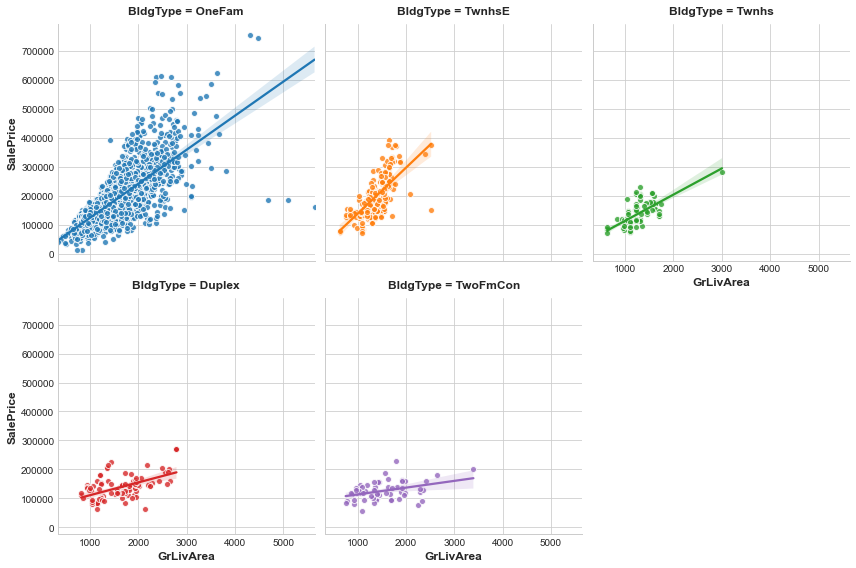

In [17]:
# YOUR CODE HERE: 
feature = "GrLivArea" 
# feature = "MoSold" 

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

Les lignes de tendance étant significativement différentes d'une catégorie à l'autre indique un effet d'interaction.

### 3) Découvrir les interactions

d'après les graphiques, `BldgType` semble-t-il présenter un effet d'interaction avec `GrLivArea` ou `MoSold` ?

### Un premier ensemble de développement de features

In [21]:
mi_scores.head(10)

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
Name: MI Scores, dtype: float64

Reconnaissez-vous les thèmes ici? Emplacement, taille et qualité. Vous n'avez pas besoin de restreindre le développement à ces seules fonctionnalités, mais vous avez maintenant un bon point de départ. La combinaison de ces principales fonctionnalités avec d'autres fonctionnalités connexes, en particulier celles que vous avez identifiées comme créant des interactions, est une bonne stratégie pour proposer un ensemble de fonctionnalités très instructif sur lesquelles entraîner votre modèle.